## 练习
* 我们使用一个新例子来巩固对**MAE**与**后验预测区间**的计算

* 在上一个例子中，我们以连续变量 *压力* 作为自变量预测*自我控制分数*

* 类别变量同样也可以作为自变量

* 这里，我们考虑一个简单的二分变量*抽烟*，将其作为自变量，来预测*自我控制分数*

In [1]:
# 导入 pymc 模型包，和 arviz 等分析工具 
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

# 忽略不必要的警告
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 通过 pd.read_csv 加载数据 Data_Sum_HPP_Multi_Site_Share.csv
df_raw = pd.read_csv('Data_Sum_HPP_Multi_Site_Share.csv')

# 筛选站点为"Tsinghua"的数据
df_METU = df_raw[df_raw["Site"] == "METU"]

# 选择需要的两列
df_METU = df_METU[["stress","scontrol","smoke"]]

#1 表示抽烟，2表示不抽烟---重新编码---0 表示不抽烟，1表示抽烟
df_METU["smoke"] =  np.where(df_METU['smoke'] == 2, 0, 1)
df_METU["smoke_recode"] =  np.where(df_METU['smoke'] == 1, "yes", "no")

#设置索引
df_METU["index"] = range(len(df_METU))
df_METU = df_METU.set_index("index")

* 在这个例子中，我们将是否抽烟作为自变量，将自我控制分数作为因变量

    * 在自变量中，`0` 表示不抽烟，`1`表示抽烟

$$
X_{i2} = \begin{cases}
1 & \text{Yes} \\
0 & \text{No} \\
\end{cases}
$$

* 简单画出两种情况下，自我控制分数分布的密度图


![Image Name](https://cdn.kesci.com/upload/s40nk3kagu.png?imageView2/0/w/960/h/960)

* 同样地，我们可以为抽烟和自我控制之间的关系建立一个正态回归模型：

$$\begin{equation}
\begin{array}{lcrl} 
\text{data:} & \hspace{.05in} & Y_i|\beta_0,\beta_1,\sigma & \stackrel{ind}{\sim} N(\mu_i, \; \sigma^2) \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1 X_{i2}\\
\text{priors:} & & \beta_{0}  &  \sim N\left(60, 2^2\right)  \\
                     & & \beta_1  & \sim N\left(-10, 4^2 \right) \\
                     & & \sigma & \sim \text{Exp}(0.6)  .\\
\end{array}
\end{equation}
$$

**在这个例子中，各参数的意义：**

* $\beta_0  =  \beta_0 + \beta_1 \cdot 0$

    * 当$X_{i2} = 0$时，$mu_i$的取值。 $\beta_0 $ 表示不抽烟情况下，自我控制分数的均值

* $\beta_0 + \beta_1 \cdot 1 = \beta_0 + \beta_1 $

    * $\beta_1 $ ：当$X_{i2} = 1$时，$mu_i$的取值。表示抽烟情况下，自我控制分数的均值，则$\beta_1 $表示了从不抽烟到抽烟，自我控制分数的变化程度

* 这里我们还是根据经验定义先验中的超参

**接下来我们直接运行模型定义、MCMC采样、后验预测部分**

In [21]:
with pm.Model() as category_model:

    beta_0 = pm.Normal("beta_0", mu=60, sigma=2)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=-10, sigma=4)         #定义beta_1
    sigma = pm.Exponential("sigma", 0.6)                  #定义sigma

    smoke = pm.MutableData("smoke",df_METU.smoke, dims="obs_id")
    mu = pm.Deterministic("mu", beta_0 + beta_1*smoke, dims="obs_id")                           #定义mu，讲自变量与先验结合

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df_METU.scontrol, dims="obs_id")   #定义似然：预测值y符合N(mu, sigma)分布
                                                                                #通过 observed 传入实际数据y 自我控制水平

In [22]:
#===========================
#     注意！！！以下代码可能需要运行1-2分钟左右
#===========================
with category_model:
    cat_regression = pm.sample(draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                      tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                      chains=4,                     # 链数
                      discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                      random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 72 seconds.


In [23]:
with category_model:
    cat_ppc = pm.sample_posterior_predictive(cat_regression,
                                             random_seed=84735) 

Sampling: [y_est]


### 代码练习

* 我们以这个新模型为例，进行对MAE、后验预测区间代码的完整练习

* 结合之前的代码，对缺失的部分进行补充

In [10]:
cat_ppc

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

### 计算MAE：

* 温馨提示：仔细查看上一行的`cat_ppc`中的各个变量，确保自己大致理解其中的含义

In [191]:
##================================================
#                练习，修改... 部分
#                
#================================================

# 计算每个X取值下对应的后验预测模型的均值
cat_pre_x = cat_ppc.posterior_predictive[...].stack(sample=("chain", "draw"))
cat_pre_y_mean = cat_pre_x.mean(axis=1).values

# 提取对应X值下的观测值Y，提取对应X值下的后验预测模型的均值
cat_MAE = pd.DataFrame({
    "smoke": ...,
    "scontrol_ppc_mean": ...,
    "scontrol_original": ...
})
cat_MAE.head(10)

,smoke,scontrol_ppc_mean,scontrol_original
index,,,
0,0,42.353902,39
1,1,35.799939,40
2,0,42.395431,40
3,0,42.326252,57
4,0,42.346681,63
5,1,35.807295,31
6,1,35.809208,40
7,1,35.749744,26
8,0,42.361468,36


In [184]:
from statistics import median

# 计算预测误差
cat_MAE["pre_error"] = cat_MAE[...] - cat_MAE[...]

# 最后，计算预测误差的中位数
MAE = median(cat_MAE.pre_error)
print(f"计算得到的MAE: {MAE:.2f}")

计算得到的MAE: 0.18


### 计算后验预测区间

In [11]:
cat_ppc

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [33]:
# 定义函数，计算对应X下的观测值超出后验预测模型hdi范围的数量
def count_outlier(i,hdi=0.94,ppc=cat_ppc):
  # 提取第i个X的值
  X = ppc.constant_data["smoke"][i].values
  # 提取第i个X值对应的后验预测值
  pre_ys = ppc.posterior_predictive["y_est"].stack(sample=("chain", "draw"))[i].values
  # 提取对应X值下的观测值Y
  true_ys = ppc.observed_data["y_est"][i].values
  
  # 计算对应后验预测的hdi的上下限
  lower,upper = az.hdi(pre_ys, hdi_prob=hdi)
  
  # 判断是否超过 hdi 边界
  outlier = (true_ys > upper) | (true_ys < lower)

  return outlier


In [35]:
# 建立一个list,存储是否超过后验预测范围的判断结果
hdi_verify = []

# 使用循环，判断所有X对应的Y是否超出后验预测范围，并计数
for i in range(len(df_METU)):  
  hdi_verify.append(count_outlier(...))
  total_number = sum(...)


print(f"所有超过后验预测范围观测值的数量: {total_number}")

所有超过后验预测范围观测值的数量: 10


In [13]:
cat_ppc

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

Text(0.5, 0, 'Smoke')

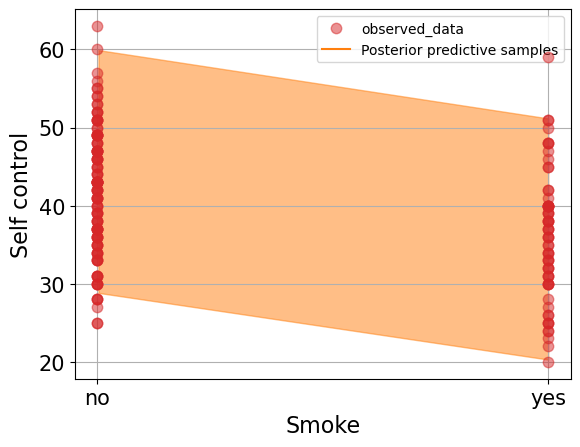

In [44]:
az.plot_lm(idata=...,           #传入后验预测的数据集
           x="...",             #传入ppc中，自变量的名称
           y="...",             #传入ppc中，观测变量的名称
           kind_pp="hdi",       #绘制可信区间
           kind_model="hdi",
           y_kwargs={"alpha":0.5})
plt.legend(loc='upper right')
plt.xticks([0,1],["no","yes"],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Self control",fontsize=16)
plt.xlabel("Smoke",fontsize=16)